# WISONet δD Retrievals
This notebook demonstrates how averaging kernels and a priori values affect satellite δD retrievals.


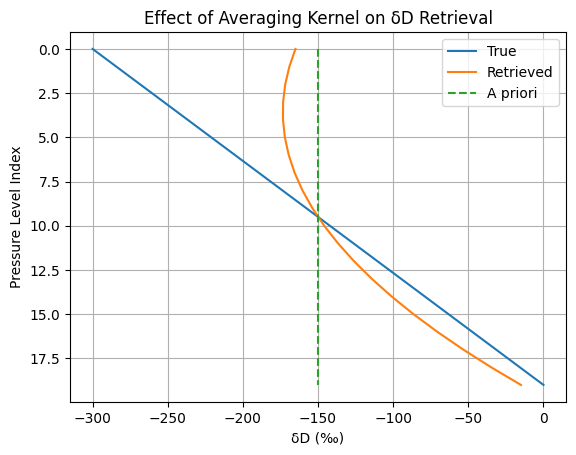

In [116]:
# Sample a priori and AK matrix
import numpy as np
import matplotlib.pyplot as plt

# Simulated state vector (true)
true_dd = np.linspace(-300, 0, 20)

# A priori: climatology
apriori = np.full(20, -150)

# Averaging kernel: diagonal dominant
AK = np.diag(np.linspace(0.1, 0.9, 20))

# Retrieved state
retrieved = apriori + AK @ (true_dd - apriori)

# Plot
plt.plot(true_dd, np.arange(20), label='True')
plt.plot(retrieved, np.arange(20), label='Retrieved')
plt.plot(apriori, np.arange(20), '--', label='A priori')
plt.gca().invert_yaxis()
plt.xlabel('δD (‰)')
plt.ylabel('Pressure Level Index')
plt.legend()
plt.title('Effect of Averaging Kernel on δD Retrieval')
plt.grid(True)
plt.show()

In [ ]:
!curl -L "https://rice.box.com/shared/static/bcoy3ob0dme3umpurqmf0p6o48bznkj1" -o SWING3_2006_subset.nc
!curl -L "https://rice.box.com/shared/static/uuy9m15qc1p7s4wm1yrzfzxc6knx7hzw" -o TES_monthly_5deg_strict.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 12.7M  100 12.7M    0     0  6217k      0  0:00:02  0:00:02 --:--:-- 51.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      9      0 --:--:--  0:00:01 --:--:-- 10000
 13 3095M   13  415M    0     0  35.0M      0  0:01:28  0:00:11  0:01:17 41.5M

In [ ]:
!ls -lh


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

ds = xr.open_dataset("SWING3_2006_subset.nc")
lon=ds['lon'].values
lat=ds['lat'].values
p=ds['p'].values
month=ds['month'].values

dD = ds['dD'].values.astype(float)  # convert to double
q = ds['q'].values.astype(float)

# === Mask out fill values ===
dD[dD == -999] = np.nan
q[q == -999] = np.nan

m=1
# === Subset latitude range [-10, 10] ===
lat_mask = (lat >= -10) & (lat <= 10)
dD_eq = dD[m, :,lat_mask, :]  # month,level,lat,lon
q_eq=q[m,:,lat_mask,:]


# === Average over lon and lat ===
dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)  # shape: [lev, time]
q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

# === Constants ===
Rvsmow = 3.1152e-4     # HDO/H2O reference ratio
M_air = 28.9647        # g/mol
M_H2O = 18.01528       # g/mol

# === Convert q from mass to VMR ===
q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))  # [mol/mol]

# === Convert δD and q to HDO VMR ===
HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)
q_eq.shape

In [ ]:

sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

import numpy as np
import xarray as xr
from datetime import datetime

# === Load dataset ===
# (Make sure you load the file before this block)
# sat = xr.open_dataset('...')

# === Load dimensions ===
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p   = sat['level'].values
tes_time = sat['time'].values  # days since 2000-01-01

# === Minimal Change: user-defined date ===
user_date_str = '2006-01-31'  # <-- set this manually or via input()
target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

# === Time matching logic ===
base_date = datetime(2000, 1, 1)
if np.issubdtype(tes_time.dtype, np.datetime64):
    t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
else:
    target_days = (target_date - base_date).days
    t_tes = np.argmin(np.abs(tes_time - target_days))

# === Spatial subset: Equatorial Pacific [-10,10] ===
ilat_tes = np.where((tes_lat >= -10) & (tes_lat <= 10))[0]
ilon_tes = np.arange(len(tes_lon))  # global

HDO_ret = sat['HDO_vmr'].values
HDO_a   = sat['HDO_ConstraintVector'].values
AK      = sat['AK_HDO'].values

lat_mask = (tes_lat >= -10) & (tes_lat <= 10)
HDO_ret = HDO_ret[t_tes, :, lat_mask, :]
HDO_a   = HDO_a[t_tes, :, lat_mask, :]
AK      = AK[t_tes, :, :, lat_mask, :]

# === Mask invalid values ===
HDO_ret[HDO_ret == -999] = np.nan
HDO_a[HDO_a == -999] = np.nan
AK[AK == -999] = np.nan

# === Average over lat and lon ===
HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

import numpy as np
import matplotlib.pyplot as plt

HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])  # reverse if p is descending

ln_true = np.log(HDO_vmr1_interp)
ln_apriori = np.log(HDO_a_avg)
ln_smoothed = ln_apriori + AK_avg @ (ln_true - ln_apriori)
HDO_recon = np.exp(ln_smoothed)

plt.figure()
plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('TES vs. Model (10S-10N Latitude, Jan 2006)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
# import numpy as np
# import xarray as xr
# from datetime import datetime, timedelta

# # === Load dimensions ===
# tes_lat = sat['lat'].values
# tes_lon = sat['lon'].values
# tes_p   = sat['level'].values
# tes_time = sat['time'].values  # days since 2000-01-01
# base_date = datetime(2000, 1, 1)
# target_date = datetime(2006, 1, 31)
# target_time_days = (target_date - base_date).days
# if np.issubdtype(tes_time.dtype, np.datetime64):
#     target_date = np.datetime64('2006-02-28')
#     t_tes = np.argmin(np.abs(tes_time - target_date))
# else:
#     base_date = datetime(2000, 1, 1)
#     target_date = datetime(2006, 2, 28)
#     target_days = (target_date - base_date).days
#     t_tes = np.argmin(np.abs(tes_time - target_days))

# # === Spatial subset: Equatorial Pacific [-10,10] ===
# ilat_tes = np.where((tes_lat >= -10) & (tes_lat <= 10))[0]
# ilon_tes = np.arange(len(tes_lon))  # full global longitude

# HDO_ret=sat['HDO_vmr'].values
# HDO_a=sat['HDO_ConstraintVector'].values
# AK=sat['AK_HDO'].values

# lat_mask = (tes_lat >= -10) & (tes_lat <= 10)
# HDO_ret = HDO_ret[t_tes, :,lat_mask, :]  # month,level,lat,lon
# HDO_a = HDO_a[t_tes, :,lat_mask, :]  # month,level,lat,lon
# AK = AK[t_tes, :,:,lat_mask, :]  # month,level,lat,lon

# # === Mask invalid values ===
# HDO_ret[HDO_ret == -999] = np.nan
# HDO_a[HDO_a == -999] = np.nan
# AK[AK == -999] = np.nan

# HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)  # shape: [lev, time]
# HDO_a_avg = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)  # shape: [lev, time]
# AK_avg = np.nanmean(np.nanmean(AK, axis=3), axis=0)  # shape: [lev, time]

# t_tes